<a href="https://colab.research.google.com/github/cabbagecongee/Particle_Transformer_Fine_Tunning/blob/main/model_pipeline_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install awkward
!pip install vector
!pip install uproot
!pip install weaver-core
!pip install fabric

In [1]:
#reference: https://github.com/jet-universe/particle_transformer/blob/main/dataloader.py

import numpy as np
import awkward as ak
import uproot
import vector
import torch
from torch.utils.data import IterableDataset
import random
vector.register_awkward()

constituent_keys = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi",
    "part_d0val", "part_d0err", "part_dzval", "part_dzerr",
    "part_charge",
    "part_isElectron", "part_isMuon", "part_isPhoton",
    "part_isChargedHadron", "part_isNeutralHadron",
    "part_pt", "part_eta", "part_phi"
]

hlf_keys = ["jet_pt", "jet_eta", "jet_phi", "jet_energy", "jet_sdmass"]
label_key = "jet_label"

def read_file(
    filepath,
    particle_features,
    jet_features,
    labels,
    max_num_particles=128,
    allowed_labels=None, 
    tau_labels=None
):
  def pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim>=2 and a.shape[1] == maxlen:
      return a
    elif isinstance(a, ak.Array):
      if a.ndim ==1:
        a = ak.unflatten(a, 1)
      a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
      return ak.values_astype(a, dtype)
    else:
      x = (np.ones((len(a), maxlen)) * value).astype(dtype)
      for idx, s in enumerate(a):
        if not len(s):
          continue
        trunc = np.asarray(s[:maxlen], dtype=dtype)
        x[idx, :len(trunc)] = trunc
      return x

  table = ak.Array(ak.from_parquet(filepath))
  num_events = len(table)

  p4 = vector.zip({
      'px': table['part_px'],
      'py': table['part_py'],
      'pz': table['part_pz'],
      'E': table['part_energy']
  })

  # Shape: (num_events, 2, max_num_particles, 4)
  v_particles = np.stack([
      ak.to_numpy(pad(p4.px, max_num_particles)),
      ak.to_numpy(pad(p4.py, max_num_particles)),
      ak.to_numpy(pad(p4.pz, max_num_particles)),
      ak.to_numpy(pad(p4.E, max_num_particles))
  ], axis=-1)

  table["part_pt"] = p4.pt
  table["part_eta"] = p4.eta
  table["part_phi"] = p4.phi

  y = ak.to_numpy(table[label_key]).astype('int64')

  if allowed_labels is not None:
    mask = np.isin(y, list(allowed_labels))
    table = table[mask]
    y = y[mask]
    y = np.array([1 if label in tau_labels else 0 for label in y])

  x_particles = np.stack([ak.to_numpy(pad(table[n], maxlen=max_num_particles)) for n in particle_features], axis=-1)
  # x_particles = np.transpose(x_particles, (0, 2, 1))

  # Mask is 1 if pt > 0 (real particle), 0 if padding
  # Shape: (num_events, max_num_particles)
  mask = (v_particles[:, :, 0]**2 + v_particles[:, :, 1]**2 > 1e-9).astype('float32')


  x_jets = np.stack([ak.to_numpy(table[n]) for n in jet_features], axis=1)

  return x_particles, x_jets, v_particles, mask, y


class JetDataset(torch.utils.data.Dataset):
  def __init__(self, parquet_file, max_num_particles=128):
    self.x_particles, self.x_jets, self.labels = read_file(
        filepath=parquet_file,
        particle_features=constituent_keys,
        jet_features=hlf_keys,
        labels=label_key
        )
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return (
        torch.tensor(self.x_particles[idx], dtype=torch.float),
        torch.tensor(self.x_jets[idx], dtype=torch.float),
        torch.tensor(self.labels[idx], dtype=torch.long)
    )


class IterableJetDataset(IterableDataset):
  def __init__(self, filepaths, shuffle_files=True, max_num_particles=128, allowed_labels=None, tau_labels=None):
    self.filepaths = filepaths
    self.shuffle_files = shuffle_files
    self.max_num_particles = max_num_particles
    self.allowed_labels = allowed_labels
    self.tau_labels = tau_labels


  def parse_files(self, filepath):
    x_particles, x_jets, v_particles, mask, labels = read_file(
      filepath=filepath,
      particle_features=constituent_keys,
      jet_features=hlf_keys,
      labels=label_key,
      max_num_particles=self.max_num_particles,
      allowed_labels=self.allowed_labels, 
      tau_labels=self.tau_labels
      )
    
    for i in range(len(labels)):
      yield(
          torch.tensor(x_particles[i], dtype=torch.float).clone(),
          torch.tensor(x_jets[i], dtype=torch.float).clone(),
          torch.tensor(v_particles[i], dtype=torch.float).clone(),
           torch.tensor(mask[i], dtype=torch.float),
          torch.tensor(labels[i], dtype=torch.long).clone(),
      )
  # def __iter__(self):
  #   if self.shuffle_files:
  #     random.shuffle(self.filepaths)
  #   for filepath in self.filepaths:
  #     yield from self.parse_files(filepath)

  def __iter__(self):
    worker_info = torch.utils.data.get_worker_info()

    if self.shuffle_files: #shuffles for each epoch
        random.shuffle(self.filepaths)

    # Determine which files this worker should process
    if worker_info is None:
        # Case 1: Single-process loading (num_workers=0)
        # The main process handles all files.
        file_list = self.filepaths
    else:
        # Case 2: Multi-process loading
        # Split the workload. Each worker gets a unique slice of the file list.
        worker_id = worker_info.id
        num_workers = worker_info.num_workers
        file_list = self.filepaths[worker_id::num_workers]

    for filepath in file_list:
        try:
            yield from self.parse_files(filepath)
        except Exception as e:
            print(f"ERROR: Worker {worker_info.id if worker_info else 0} failed to process {filepath}. Reason: {e}. Skipping file.")
            continue

In [1]:
! wget --no-verbose https://github.com/jet-universe/sophon/raw/main/notebooks/JetClassII_example.parquet

2025-08-16 13:09:35 URL:https://raw.githubusercontent.com/jet-universe/sophon/main/notebooks/JetClassII_example.parquet [447746/447746] -> "JetClassII_example.parquet" [1]


In [2]:
filepaths = ["JetClassII_example.parquet"] 
dataset = IterableJetDataset(filepaths, max_num_particles=128)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    num_workers=0
)

for x_particles, x_jets, v_particles, mask, labels in dataloader:
    print(x_particles.shape) #[batch size, num jets, particle features]
    print(x_jets.shape) # [batch size, num jets, jet features (HLFs)]
    print(v_particles.shape)
    print(mask.shape)
    print(labels.shape) # [batch size]
    break

torch.Size([32, 128, 19])
torch.Size([32, 5])
torch.Size([32, 128, 4])
torch.Size([32, 128])
torch.Size([32])


In [16]:
unique_classes = np.unique(dataset.labels)
print(f"Unique classes found: {unique_classes} ")
print(f"Num classes: {len(unique_classes)}")

AttributeError: 'IterableJetDataset' object has no attribute 'labels'

In [3]:
# model.py
''' Particle Transformer (ParT)

Paper: "Particle Transformer for Jet Tagging" - https://arxiv.org/abs/2202.03772
'''

#source: https://github.com/hqucms/weaver-core/blob/main/weaver/nn/model/ParticleTransformer.py

import math
import random
import warnings
import copy
import torch
import torch.nn as nn
from functools import partial

from weaver.utils.logger import _logger


@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu


class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y


class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio

        self.pre_attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=attn_dropout,
            add_bias_kv=add_bias_kv,
        )
        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, self.ffn_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None
        self.fc2 = nn.Linear(self.ffn_dim, embed_dim)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None

    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None):
        """
        Args:
            x (Tensor): input to the layer of shape `(seq_len, batch, embed_dim)`
            x_cls (Tensor, optional): class token input to the layer of shape `(1, batch, embed_dim)`
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape `(batch, seq_len)` where padding
                elements are indicated by ``1``.

        Returns:
            encoded output of shape `(seq_len, batch, embed_dim)`
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)
            x = self.attn(x_cls, u, u, key_padding_mask=padding_mask)[0]  # (1, batch, embed_dim)
        else:
            residual = x
            x = self.pre_attn_norm(x)
            x = self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask)[0]  # (seq_len, batch, embed_dim)

        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)
        x += residual

        residual = x
        x = self.pre_fc_norm(x)
        x = self.act(self.fc1(x))
        x = self.act_dropout(x)
        if self.post_fc_norm is not None:
            x = self.post_fc_norm(x)
        x = self.fc2(x)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        return x


class ParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.for_inference = for_inference
        self.use_amp = use_amp

        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        self.blocks = nn.ModuleList([Block(**cfg_block) for _ in range(num_layers)])
        self.cls_blocks = nn.ModuleList([Block(**cfg_cls_block) for _ in range(num_cls_layers)])
        self.norm = nn.LayerNorm(embed_dim)

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            for block in self.blocks:
                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)
            # print('output:\n', output)
            return output


class ParticleTransformerTagger(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            pf_x, pf_v, pf_mask, _ = self.pf_trimmer(pf_x, pf_v, pf_mask)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask)


class ParticleTransformerTaggerWithExtraPairFeatures(nn.Module):

    def __init__(self,
                 pf_input_dim,
                 sv_input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.use_amp = use_amp
        self.for_inference = for_inference

        self.pf_trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.sv_trimmer = SequenceTrimmer(enabled=trim and not for_inference)

        self.pf_embed = Embed(pf_input_dim, embed_dims, activation=activation)
        self.sv_embed = Embed(sv_input_dim, embed_dims, activation=activation)

        self.part = ParticleTransformer(input_dim=embed_dims[-1],
                                        num_classes=num_classes,
                                        # network configurations
                                        pair_input_dim=pair_input_dim,
                                        pair_extra_dim=pair_extra_dim,
                                        remove_self_pair=remove_self_pair,
                                        use_pre_activation_pair=use_pre_activation_pair,
                                        embed_dims=[],
                                        pair_embed_dims=pair_embed_dims,
                                        num_heads=num_heads,
                                        num_layers=num_layers,
                                        num_cls_layers=num_cls_layers,
                                        block_params=block_params,
                                        cls_block_params=cls_block_params,
                                        fc_params=fc_params,
                                        activation=activation,
                                        # misc
                                        trim=False,
                                        for_inference=for_inference,
                                        use_amp=use_amp)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'part.cls_token', }

    def forward(self, pf_x, pf_v=None, pf_mask=None, sv_x=None, sv_v=None, sv_mask=None, pf_uu=None, pf_uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0

        with torch.no_grad():
            if not self.for_inference:
                if pf_uu_idx is not None:
                    pf_uu = build_sparse_tensor(pf_uu, pf_uu_idx, pf_x.size(-1))

            pf_x, pf_v, pf_mask, pf_uu = self.pf_trimmer(pf_x, pf_v, pf_mask, pf_uu)
            sv_x, sv_v, sv_mask, _ = self.sv_trimmer(sv_x, sv_v, sv_mask)
            v = torch.cat([pf_v, sv_v], dim=2)
            mask = torch.cat([pf_mask, sv_mask], dim=2)
            uu = torch.zeros(v.size(0), pf_uu.size(1), v.size(2), v.size(2), dtype=v.dtype, device=v.device)
            uu[:, :, :pf_x.size(2), :pf_x.size(2)] = pf_uu

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            pf_x = self.pf_embed(pf_x)  # after embed: (seq_len, batch, embed_dim)
            sv_x = self.sv_embed(sv_x)
            x = torch.cat([pf_x, sv_x], dim=0)

            return self.part(x, v, mask, uu)

In [4]:
class ParticleTransformerBackbone(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=None,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[128, 512, 128],
                 pair_embed_dims=[64, 64, 64],
                 num_heads=8,
                 num_layers=8,
                 num_cls_layers=2,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.for_inference = for_inference
        self.use_amp = use_amp

        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        self.blocks = nn.ModuleList([Block(**cfg_block) for _ in range(num_layers)])
        self.cls_blocks = nn.ModuleList([Block(**cfg_cls_block) for _ in range(num_cls_layers)])
        self.norm = nn.LayerNorm(embed_dim)

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            for block in self.blocks:
                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            return output

In [7]:
# test model

model = ParticleTransformerBackbone(
    input_dim=19,          # number of particle features
    num_classes=20,        # number of jet classes in JetClassII
    num_heads=2,           # match default
    num_layers=4,          # match default
)

print(model)


ParticleTransformerBackbone(
  (trimmer): SequenceTrimmer()
  (embed): Embed(
    (input_bn): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (embed): Sequential(
      (0): LayerNorm((19,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=19, out_features=128, bias=True)
      (2): GELU(approximate='none')
      (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): GELU(approximate='none')
      (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (7): Linear(in_features=512, out_features=128, bias=True)
      (8): GELU(approximate='none')
    )
  )
  (pair_embed): PairEmbed(
    (embed): Sequential(
      (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3)

Epoch 1/50: 0it [00:00, ?it/s]

/var/folders/x5/nk2s0y9j023dsj349jm6v7fh0000gn/T/ipykernel_52199/2604744380.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
Epoch 1/50: 4it [00:03,  1.00it/s]


Epoch 1/50, Loss: 5.2572, Accuracy: 0.0100


Epoch 2/50: 4it [00:02,  1.57it/s]


Epoch 2/50, Loss: 4.5776, Accuracy: 0.1500


Epoch 3/50: 4it [00:01,  2.78it/s]


Epoch 3/50, Loss: 4.1495, Accuracy: 0.2000


Epoch 4/50: 4it [00:01,  3.04it/s]


Epoch 4/50, Loss: 3.8432, Accuracy: 0.2000


Epoch 5/50: 4it [00:01,  2.32it/s]


Epoch 5/50, Loss: 3.5887, Accuracy: 0.2100


Epoch 6/50: 4it [00:01,  2.40it/s]


Epoch 6/50, Loss: 3.4057, Accuracy: 0.2400


Epoch 7/50: 4it [00:01,  3.02it/s]


Epoch 7/50, Loss: 3.2416, Accuracy: 0.2300


Epoch 8/50: 4it [00:01,  3.36it/s]


Epoch 8/50, Loss: 3.0896, Accuracy: 0.2300


Epoch 9/50: 4it [00:01,  2.75it/s]


Epoch 9/50, Loss: 2.9447, Accuracy: 0.2700


Epoch 10/50: 4it [00:01,  2.97it/s]


Epoch 10/50, Loss: 2.8057, Accuracy: 0.3100


Epoch 11/50: 4it [00:01,  2.85it/s]


Epoch 11/50, Loss: 2.6584, Accuracy: 0.3200


Epoch 12/50: 4it [00:01,  2.98it/s]


Epoch 12/50, Loss: 2.5346, Accuracy: 0.4300


Epoch 13/50: 4it [00:01,  2.77it/s]


Epoch 13/50, Loss: 2.4351, Accuracy: 0.4800


Epoch 14/50: 4it [00:01,  3.09it/s]


Epoch 14/50, Loss: 2.3039, Accuracy: 0.5500


Epoch 15/50: 4it [00:01,  3.10it/s]


Epoch 15/50, Loss: 2.1831, Accuracy: 0.5600


Epoch 16/50: 4it [00:01,  2.45it/s]


Epoch 16/50, Loss: 2.0881, Accuracy: 0.5900


Epoch 17/50: 4it [00:01,  2.90it/s]


Epoch 17/50, Loss: 1.9854, Accuracy: 0.6600


Epoch 18/50: 4it [00:01,  3.25it/s]


Epoch 18/50, Loss: 1.8807, Accuracy: 0.6800


Epoch 19/50: 4it [00:01,  3.19it/s]


Epoch 19/50, Loss: 1.7873, Accuracy: 0.7100


Epoch 20/50: 4it [00:01,  3.21it/s]


Epoch 20/50, Loss: 1.6982, Accuracy: 0.7600


Epoch 21/50: 4it [00:01,  3.36it/s]


Epoch 21/50, Loss: 1.6064, Accuracy: 0.7800


Epoch 22/50: 4it [00:01,  3.05it/s]


Epoch 22/50, Loss: 1.5205, Accuracy: 0.8400


Epoch 23/50: 4it [00:01,  2.88it/s]


Epoch 23/50, Loss: 1.4230, Accuracy: 0.8700


Epoch 24/50: 4it [00:01,  3.00it/s]


Epoch 24/50, Loss: 1.3477, Accuracy: 0.9100


Epoch 25/50: 4it [00:01,  3.37it/s]


Epoch 25/50, Loss: 1.2722, Accuracy: 0.9300


Epoch 26/50: 4it [00:01,  3.40it/s]


Epoch 26/50, Loss: 1.1963, Accuracy: 0.9400


Epoch 27/50: 4it [00:01,  3.07it/s]


Epoch 27/50, Loss: 1.1298, Accuracy: 0.9700


Epoch 28/50: 4it [00:01,  3.34it/s]


Epoch 28/50, Loss: 1.0637, Accuracy: 0.9900


Epoch 29/50: 4it [00:01,  3.46it/s]


Epoch 29/50, Loss: 0.9983, Accuracy: 0.9900


Epoch 30/50: 4it [00:01,  3.38it/s]


Epoch 30/50, Loss: 0.9302, Accuracy: 1.0000


Epoch 31/50: 4it [00:01,  3.42it/s]


Epoch 31/50, Loss: 0.8728, Accuracy: 1.0000


Epoch 32/50: 4it [00:01,  3.41it/s]


Epoch 32/50, Loss: 0.8209, Accuracy: 1.0000


Epoch 33/50: 4it [00:01,  2.88it/s]


Epoch 33/50, Loss: 0.7756, Accuracy: 1.0000


Epoch 34/50: 4it [00:01,  2.86it/s]


Epoch 34/50, Loss: 0.7439, Accuracy: 1.0000


Epoch 35/50: 4it [00:01,  3.16it/s]


Epoch 35/50, Loss: 0.6992, Accuracy: 1.0000


Epoch 36/50: 4it [00:01,  3.25it/s]


Epoch 36/50, Loss: 0.6587, Accuracy: 1.0000


Epoch 37/50: 4it [00:01,  3.06it/s]


Epoch 37/50, Loss: 0.6221, Accuracy: 1.0000


Epoch 38/50: 4it [00:01,  3.33it/s]


Epoch 38/50, Loss: 0.5942, Accuracy: 1.0000


Epoch 39/50: 4it [00:01,  3.10it/s]


Epoch 39/50, Loss: 0.5650, Accuracy: 1.0000


Epoch 40/50: 4it [00:01,  2.89it/s]


Epoch 40/50, Loss: 0.5361, Accuracy: 1.0000


Epoch 41/50: 4it [00:01,  3.33it/s]


Epoch 41/50, Loss: 0.5153, Accuracy: 1.0000


Epoch 42/50: 4it [00:01,  2.84it/s]


Epoch 42/50, Loss: 0.4879, Accuracy: 1.0000


Epoch 43/50: 4it [00:01,  2.83it/s]


Epoch 43/50, Loss: 0.4829, Accuracy: 1.0000


Epoch 44/50: 4it [00:01,  2.91it/s]


Epoch 44/50, Loss: 0.4513, Accuracy: 1.0000


Epoch 45/50: 4it [00:01,  2.99it/s]


Epoch 45/50, Loss: 0.4300, Accuracy: 1.0000


Epoch 46/50: 4it [00:01,  2.69it/s]


Epoch 46/50, Loss: 0.4106, Accuracy: 1.0000


Epoch 47/50: 4it [00:01,  2.97it/s]


Epoch 47/50, Loss: 0.3946, Accuracy: 1.0000


Epoch 48/50: 4it [00:01,  2.75it/s]


Epoch 48/50, Loss: 0.3770, Accuracy: 1.0000


Epoch 49/50: 4it [00:01,  2.76it/s]


Epoch 49/50, Loss: 0.3672, Accuracy: 1.0000


Epoch 50/50: 4it [00:01,  3.19it/s]

Epoch 50/50, Loss: 0.3574, Accuracy: 1.0000


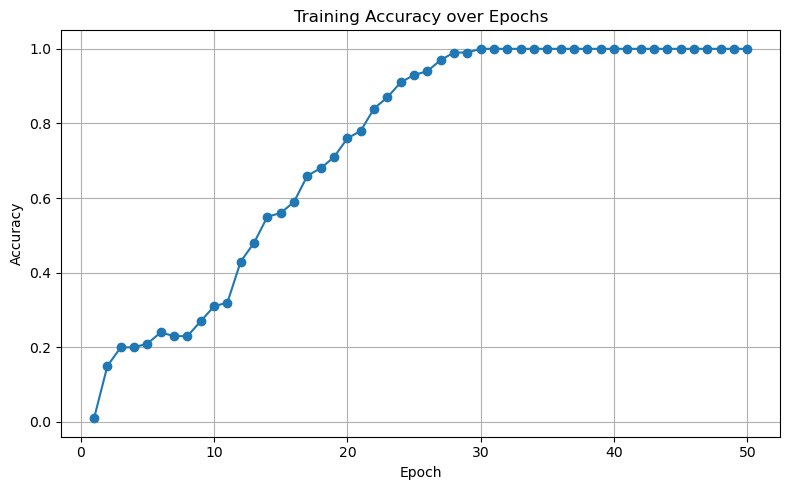

In [11]:
# train.py

import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 50
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
filepaths = ["JetClassII_example.parquet"]
train_dataset = IterableJetDataset(filepaths, max_num_particles=128)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0)

model = ParticleTransformerBackbone(
    input_dim=19,          # number of particle features
    num_classes=188,       # number of jet classes in JetClassII
    num_layers=1
  ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

acc = []

model.train()
for epoch in range(EPOCHS):
  total_loss = 0.0
  correct = 0
  total = 0
  num_batches = 0 
  for x_particles, x_jets, v_particles, mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
    x_particles = x_particles.to(device)
    v_particles = v_particles.to(device)
    mask = mask.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(
            x=x_particles.transpose(1, 2),
            v=v_particles.transpose(1, 2),
            mask=mask.unsqueeze(1)
        )

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    _, pred = outputs.max(1)
    correct += (pred == labels).sum().item()
    total += labels.size(0)
    num_batches += 1

  epoch_acc = correct / total if total > 0 else 0
  epoch_loss = total_loss / num_batches if num_batches > 0 else 0
  acc.append(epoch_acc)
  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()